# YOLOv11 Classification Dataset Pipeline

Pipeline to process a **Label Studio JSON-MIN export** into an augmented YOLO classification dataset.

## Input
- **JSON-MIN export**: Contains image paths and labels
- **Images folder**: From YOLO OBB export (reused for CLS)

## Output
```
cls_dataset/
├── train/
│   ├── 2/
│   ├── 3/
│   ├── ...
│   └── SwitchCard/
├── val/
└── train_cfg.yaml
```

## 1) Imports

In [1]:
from config_loader import CONFIG

In [2]:
from pathlib import Path

from yolo_dataset import (
    ClassificationProcessor,
    ClassificationConfig,
    ClassificationField,
    ClsAugmentationConfig,
)

## 2) Configuration

In [3]:
# ============================================================
# === CONFIGURATION - EDIT THESE VALUES ===
# ============================================================

# Input: Label Studio exports
JSON_PATH = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\label_studio_exports\label_studio_export_cls_dataset_json_min.json")   # JSON-MIN export

IMAGES_DIR = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\label_studio_exports\label_studio_export_cls_dataset_yolov8_with_images\images")     # Images from OBB export

# Output: Parent directory for datasets
OUTPUT_DIR = Path(r"./datasets/label_studio_export_cls_dataset_augmented")

# Label key in JSON (None = auto-detect)
LABEL_KEY = None  # e.g., "label", "choice", "rank"

# Split ratios
VAL_SPLIT = 0.15
TEST_SPLIT = 0.0

# Random seed
SEED = 42

# Augmentation settings
NUM_AUGMENTED = 4  # Number of augmented copies per image

# Training settings
MODEL = "yolo11s-cls.pt"
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 16
DEVICE = 0
PATIENCE = 20

## 3) Initialize Processor

In [4]:
# Validate paths
assert JSON_PATH.exists(), f"JSON not found: {JSON_PATH}"
assert IMAGES_DIR.exists(), f"Images not found: {IMAGES_DIR}"

# Create config
config = ClassificationConfig(
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    seed=SEED,
)

# Initialize processor
processor = ClassificationProcessor(
    json_path=JSON_PATH,
    images_dir=IMAGES_DIR,
    output_dir=OUTPUT_DIR,
    config=config,
)

Loaded 236 items from JSON
Indexed 236 images


## 4) Analyze JSON and Detect Classes

In [5]:
# Analyze JSON structure
potential_fields = processor.analyze_json()

print("Detected label fields:")
print("="*60)
for key, values in potential_fields.items():
    print(f"\n'{key}' ({len(values)} classes):")
    print(f"  {values}")

Detected label fields:

'rank' (13 classes):
  ['2', '3', '4', '5', '6', '7', '8', 'A', 'DealerCard', 'J', 'K', 'Q', 'SwitchCard']


In [6]:
# Auto-detect or select field
processor.auto_detect_fields(label_key=LABEL_KEY)

# Show selected field
for field in processor.config.fields:
    print(f"\nField: {field.json_key}")
    print(f"Classes ({len(field.class_names)}): {field.class_names}")


Detected label fields:
  'rank': 13 classes -> ['2', '3', '4', '5', '6']...

Selected: 'rank' with 13 classes

Field: rank
Classes (13): ['2', '3', '4', '5', '6', '7', '8', 'A', 'DealerCard', 'J', 'K', 'Q', 'SwitchCard']


## 5) Process Dataset

In [7]:
# Create augmentation config
aug_config = ClsAugmentationConfig(
    num_augmented=NUM_AUGMENTED,
    flip_horizontal=0.5,
    rotation_range=15.0,
    brightness_range=(0.7, 1.3),
    contrast_range=(0.8, 1.2),
    saturation_range=(0.7, 1.3),
    noise_probability=0.1,
    blur_probability=0.1,
)

print("Augmentation config:")
print(f"  Copies per image: {aug_config.num_augmented}")
print(f"  Flip horizontal: {aug_config.flip_horizontal}")
print(f"  Rotation: ±{aug_config.rotation_range}°")

Augmentation config:
  Copies per image: 4
  Flip horizontal: 0.5
  Rotation: ±15.0°


In [8]:
# Process dataset
report = processor.process(
    apply_augmentation=True,
    aug_config=aug_config,
    generate_configs=True,
    training_params={
        "model": MODEL,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "device": DEVICE,
        "patience": PATIENCE,
    }
)


Processing: rank_dataset
  Groups: 236 | Processed: 236 | Missing: 0 | Bad labels: 0
  ✓ Copied 236 images

Applying augmentation...
  ✓ rank_dataset/train: 200 original + 800 augmented

Generating config...
  ✓ Generated: datasets\label_studio_export_cls_dataset_augmented\rank_dataset\train_cfg.yaml

✅ Classification processing complete!


## 6) Dataset Statistics

In [9]:
stats = processor.get_stats()

for ds_name, ds_stats in stats.items():
    print(f"\n{'='*60}")
    print(f"Dataset: {ds_name}")
    print(f"{'='*60}")
    print(f"Classes: {len(ds_stats['classes'])}")
    
    for split, split_info in ds_stats.get('splits', {}).items():
        print(f"\n  {split.upper()}: {split_info['total']} images")
        for cls_name, count in sorted(split_info['per_class'].items()):
            if count > 0:
                print(f"    {cls_name:15s}: {count:4d}")


Dataset: rank_dataset
Classes: 13

  TRAIN: 1000 images
    2              :   15
    3              :   65
    4              :   45
    5              :   65
    6              :   55
    7              :   80
    8              :   85
    A              :  125
    DealerCard     :   75
    J              :   65
    K              :  205
    Q              :   35
    SwitchCard     :   85

  VAL: 36 images
    2              :    1
    3              :    4
    4              :    1
    5              :    5
    6              :    3
    7              :    2
    8              :    4
    A              :    1
    DealerCard     :    3
    J              :    4
    K              :    3
    SwitchCard     :    5


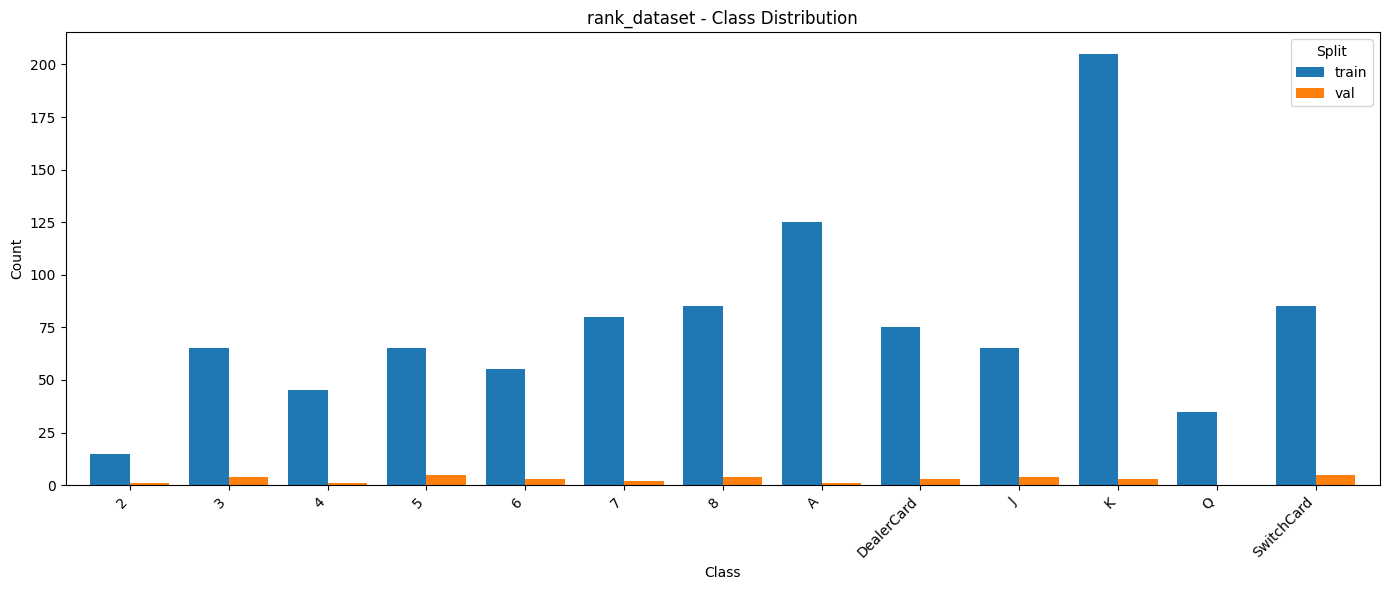

In [10]:
# Visualize distribution
import matplotlib.pyplot as plt
import pandas as pd

for ds_name, ds_stats in stats.items():
    data = {}
    for split, split_info in ds_stats.get('splits', {}).items():
        data[split] = split_info['per_class']
    
    df = pd.DataFrame(data).fillna(0).astype(int)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    df.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f"{ds_name} - Class Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.legend(title="Split")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7) Preview Samples

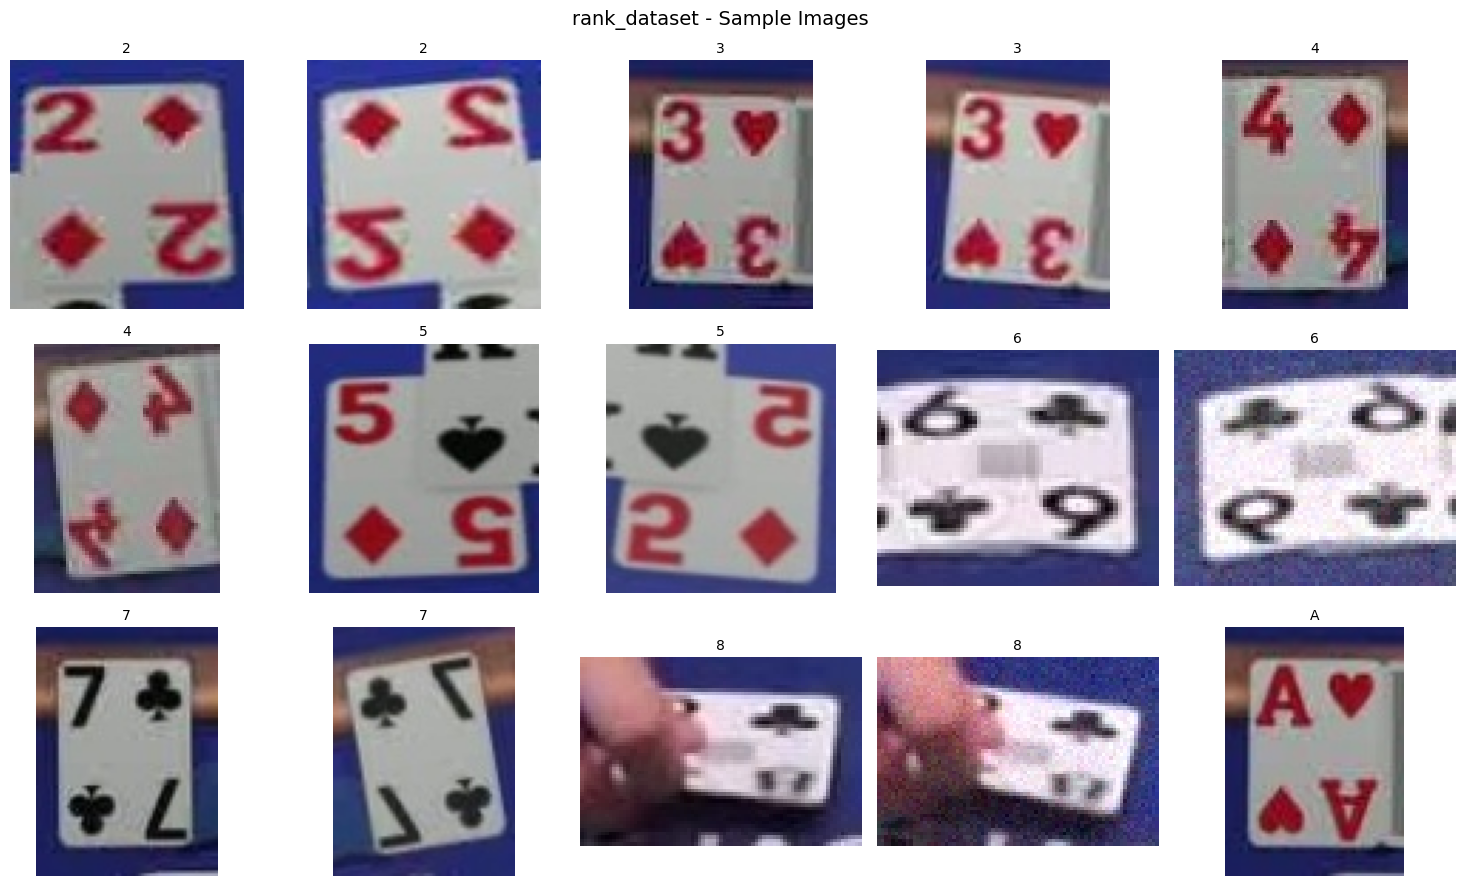

In [11]:
import cv2

for field in processor.config.fields:
    ds_root = OUTPUT_DIR / field.dataset_name / "train"
    
    if not ds_root.exists():
        continue
    
    # Get samples from each class
    samples = []
    for cls_dir in sorted(ds_root.iterdir()):
        if cls_dir.is_dir():
            images = list(cls_dir.glob("*"))[:2]
            for img_path in images:
                samples.append((cls_dir.name, img_path))
    
    # Plot
    n = min(15, len(samples))
    cols = 5
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()
    
    for i, (cls_name, img_path) in enumerate(samples[:n]):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(cls_name, fontsize=10)
        axes[i].axis("off")
    
    for i in range(n, len(axes)):
        axes[i].axis("off")
    
    plt.suptitle(f"{field.dataset_name} - Sample Images", fontsize=14)
    plt.tight_layout()
    plt.show()

## 8) Training Command

In [12]:
commands = processor.get_training_commands()

print("="*60)
print("TRAINING COMMANDS")
print("="*60)

for ds_name, cmd in commands.items():
    print(f"\n{ds_name}:")
    print(f"  {cmd}")

TRAINING COMMANDS

rank_dataset:
  yolo train cfg="datasets\label_studio_export_cls_dataset_augmented\rank_dataset\train_cfg.yaml"
